In [1]:
# Allow us to load `open_cp` without installing
import sys, os.path
sys.path.insert(0, os.path.abspath(".."))

# Sources

1. Kulldorff et al, "A Space–Time Permutation Scan Statistic for Disease Outbreak Detection", PLoS Med 2(3): e59, DOI:10.1371/journal.pmed.0020059
2. Kulldorff M. and Information Management Services, Inc. SaTScanTM v8.0: Software for the spatial and space-time scan statistics. http://www.satscan.org/, 2009.
3. Cheng, Adepeju, "Modifiable Temporal Unit Problem (MTUP) and Its Effect on Space-Time Cluster Detection", PLOS ONE 9(6): e100465. DOI:10.1371/journal.pone.0100465
4. Adepeju, Rosser, Cheng, "Novel evaluation metrics for sparse spatiotemporal point process hotspot predictions - a crime case study", International Journal of Geographical Information Science, 30:11, 2133-2154, DOI:10.1080/13658816.2016.1159684

# Discussion

The "Space-Time (Permutation) Scan Statistic" comes from a family of statistical tests for clustering in space-time point process data.  The freely available ("free as in beer"; source code is seemingly not available) software (2) implements a variety of cluster detection algorithms.  The particular algorithm we are interested in was first proposed in (1).

The basic idea is to look at the space-time data, and to consider all possible "cylinders": pick a location $(x,y)$ in space, a radius $r$ and a start and end time, $t_s, t_e$.  Then we consider all (space) points within distance $r$ of $(x,y)$, and all time points $t_s \leq t \leq t_e$ (visualised in three dimensions, this is indeed a cylinder).  We then have a choice of an underlying statistical model which allows us to compute the expected number of events in the cylinder.  We compare this expected number against the actual number of events which occurred, and single out the most "extreme" cylinder as our (primary) cluster.  Once done, we can then single out other cylinders as "secondary" clusters.

The user-manual (2) contains a large bibliography, including applications to crime analysis.  We shall follow (3) and (4) as they give fairly precise details of how the software (2) was used.  The website of (2) also lists other software, but none of these packages seem to implement the "permutation" algorithm discussed here.

See the notebook `SaTScan Replication.ipynb` for explication of some of the analyses which (2) can perform.

# Derivation of the algorithm

We follow (1) but make some comments to allow us to treat data which is more "continuous".  Following (1), suppose we have that events can occur in a number of regions indexed by $z$ (for zip-code in the original) and in time regions indexed by $d$ (for days in the original).  Let $c_{z,d}$ be the count of events occurring in space region $z$ and time region $d$, so that the total number of events is
$$ N = \sum_{z,d} c_{z,d}. $$
We conditional on the marginals to obtain the expected number of events at $(z,d)$ as
$$ \mu_{z,d} = \frac{1}{N} \Big( \sum_{z'} c_{z',d} \Big) \Big( \sum_{d'} c_{z,d'} \Big). $$
The probabilistic assumption we have made here is that, if $e$ is a randomly chosen event from the $N$ total events, then the probability that $e$ is in region $z$, given it occurred in time region $d$, is the same for any choice of $d$ (and with the roles of $z$ and $d$ reversed).  If $A$ is some space-time region, then the expected number of events in region $A$ is
$$ \mu_A = \sum_{(z,d)\in A} \mu_{z,d}. $$
Our statistical test will be to compare the actual number of events which occur in $A$ against $\mu_A$, to detect regions where there is a significant departure from the expected number.

First, let us expand upon the definition of $\mu_A$.  In all cases we are interested in, $A$ will be a space-time "cylinder", meaning in particular that $A = B \times C$ where $B$ is some subset of space, and $C$ is some subset of time.  Then
$$ \mu_A = \mu_{B\times C} = \sum_{z\in B, d\in C} \mu_{z,d}
= \frac{1}{N} \Big( \sum_{z', d\in C} c_{z',d} \Big) \Big( \sum_{z\in B, d'} c_{z,d'} \Big). $$
In this form, it is easy to extend the definition to the case when the data is not "binned" into regions, but where we have point events occuring at space-time coordinates $(s_i,t_i)$ for $i=1,\ldots,N$:
$$ \mu_A = \frac{1}{N} \#\{ i : t_i\in C\} \#\{ i : s_i\in B \}, $$
where, for example, $\#\{ i : t_i\in C\}$ denotes the number of events which occur in time region $C$, and anywhere in space.

Continuing with following (1), we approximate, and consider the Poisson generalised likelihood ratio
$$ \Big(\frac{c_A}{\mu_A}\Big)^{c_A} \Big(\frac{N-c_A}{N-\mu_A}\Big)^{(N-c_A)} $$
Here $c_A$ denotes the number of events which actually occurred in space-time cylinder $A$, and $\mu_A$ is as before.  We search for the $A$ with this ratio being greatest.  (2) introduces a further factor, and multiplies by
$$ I(c_A > \mu_A) = \begin{cases} 1 : c_A > \mu_A, \\ 0 : c_A\leq \mu_A. \end{cases} $$
That is, we set the likelihood to be identically $0$ when there are fewer than expected events.  This ensures we single out only actual clusters, and not regions which are "non-clusters" (regions where there are many fewer than expected events).

We effectively test an infinite number of cylinders, and so simple hypothesis testing is not applicable (because of "multiple testing").  Instead we use Monte Carlo hypothesis testing: the idea here is to randomly generate data which has the same "distribution" as the real data, and to see how likely (or not) our statistic is.  In this case, we use the "permutation" from the title of (1).  We take the actual data, and then randomly shuffle the timestamps, while keeping the space locations to the same.  This does not change the marginal distributions.  For each such randomly chosen permutation, we re-calculate the likelihood ratio as above, finding the (possibly new) cylinder with the greatest value.  In this way we collect samples from the "typical" largest likelihood ratio, and then compare our actual value against this.  If we repeat this$n-1$ times, we can then rank the real data as being the $r$ th largest ratio.  Then the "$p$-value" of the cylinder is $r/n$.

To find the "most clustered" cylinder we find the cylinder with the largest statistic (i.e. largest value of the (log) generalised likelihood ratio).  Notice that this is the same as the cylinder with the smallest $p$-value.  (Which is useful, as if we are interested in prediction only, we may not need to actually estimate the $p$-value at all, thus saving a lot of computational time.  Of course, the $p$-value does give some indication of how much we might trust the prediction.)

Once done, we could find the next most extreme cylinder.  However, this will be essentially the same, as slightly deforming a cylinder will, in general, not change the likelihood (it will only change if the deformed cylinder contains more or fewer points, which won't happen for a sufficiently small change).  It is common then to only look at cylinders which are disjoint from the cylinders already singled out.  This is the approach taken in (3) (and presumably (4)).

An alternative, implemented in (2), is to delete the data points which occur in the previously identified clusters, and then re-run the entire process.  This can lead to overlapping cylinders, but these now have some statistical content-- as suggested in (2), we might expect a cluster in the very centre of city, and then a larger cluster formed from the "donut shape" of the inner urban area of a city, exluding the very centre.

Finally, a note on optimisations.  We obviously cannot consider all possible cylinders, as there are an infinite number.  As noted above, as both real and simulated data has the same space and time locations (though perhaps with the link between space and time "permuted") if two cylinders contain the same events, then they will always return the same likelihood.  Thus we need only consider cylinders which contain one point each, then cylinders which contain 2 points each, and so forth.  We also limit cylinders to not be above a certain size, or to contain too much of the data.

## Prospective vs Retrospective analysis

We follow (2).  For a "prospective" analysis, we only consider space/time cylinders where time extends up to the present.  For a retrospective analysis, one would look at all time intervals; but we shall not implement this option here.

## Limiting the search

The default settings in (2) are to apply some limits:

- No space disk should contain more than 50% of the population of events
- No space disk should have a radius of over x metres (x=3000 by default)
- No time interval should be more than 50% of the total time (or specify a maximum length).
- For a prospective analysis, we look at a time unit of days (so bin the timestamps into days) and look at time cylinders of length 1, 2, ..., 7 days (starting from now, as this is a propsective analysis).
- Only report clusters with a certain cutoff $p$-value.  This seems to vary (by default) in (2) with the number of monte carlo replications performed (so that adding more monte carlo replications, which leads to a higher resolution in the estimated $p$-value, also in general leads to more clusters being detected).

The paper (3) (see discussion on page 6) uses a radius of 1000 metres.  See (3) for an extensive discussion on the problem of arbitrarily binning timestamps into (large) bins.

## Converting to a grid-based risk algorithm

The paper (4) does not discuss the settings used in (2) (assuming, as we do, that (2) was actually used).  However, we have the following two quotes:

> Overlaying a regular grid on the circularly clustered surface, we
rank all grid squares that intersect a cluster, first by the p-value of the overlapping
cluster, then by distance from the cluster centre.

> As PSTSS returns only those clusters that persist until the current day, no such threshold is necessary and we simply consider all clusters.

Here PSTSS stands for "Prospective space-time scan statistic".  The algorithm for assigning risk to the grids looks at the cluster with lowest $p$-value (as above, equivalently the highest statistic) and then assigns the centre grid cell of that cluster the highest overall risk; then it's neighbours the next highest risk, and so forth until all grid cells in the clsuter are flagged.  Then the next highest rated cluster is considered, and so on.

Thus this algorithm does not really return a "relative risk", but rather much more explicitly tries to answer the question: "Which `x`% of the grid cells are most at risk?"

# Prospective algorithm description

Optionally we can bin the data:

- Assign the timestamps of events to the nearest hour, day, week etc.
- Assign the space location of events to the centre-point of a regular grid.

Optionally we can limit the search space:

- Each space disk region to contain at most x% of the data (default 50%)
- Each space disk region to have a maximum radius (default 1000m)
- Each time region to contain at most x% of the data (default 50%)
- Each time region to be of a maximum length (default 3 months)

Under these constraints, we look at all possible space disks, and all possible time intervals.  _Each cluster must contain at least two events._ (This constraint is in SaTScan.)

### Time intervals

We only consider time intervals ending at the end of the data time (the "prediction time").  Let $t_1<t_2<\cdots<t_n$ be the unique timestamps of events which follow the constraints above.  We need to consider the intervals which contain the events $\{t_n\}$, then $\{t_{n-1},t_n\}$, then $\{t_{n-2}, t_{n-1}, t_n\}$, and so forth, up to the whole interval $\{t_1,\cdots,t_n\}$.

### Space regions

We need to consider all possible circular discs-- but if two discs contain the same events, we should consider the discs equivalent.

I believe (from experimentation) that the software (2) constructs disks by having the centre of a disk always one of the events, and varying the radii of the disk.  This does not lead to a consideration of all possible disks (to see a counter example, draw a circle, place three points forming an equilateral triangle insider the circle, and place lots of points just outside the circle.  The circle gives a disk containing three points, but there is no disk which is centred on some point and equivalent to our circle.)

Given $n$ points in the plane, it seems difficult to determine if there is a disk containing those points and only those points.  Even the task of finding the smallest circle enclosing $k$ points, while not computationally "hard", is at least non-trivial (see [Wikipedia](https://en.wikipedia.org/wiki/Smallest-circle_problem)).  **We propose to stick to the algorithm of only looking at disks centred on each event**.

As such, the algorithm is to consider each event in turn, and then to consider the disks centred on that event.  We consider the disk containing just the event itself; then the disk containing the event and it's nearest neighbour; then the disk containing the two nearest neighbours, and so forth.

### Computing p-values

We shall not implement computing $p$-values at this stage.  Given the above discussion, for the current prediction method, $p$-values are not needed, as we can simply use the value of the statistic when deciding what is a cluster (we just have no good notion of how "likely" we really have a cluster, but such a notion is not used in prediction).

### Algorithm

Given all choices $\mathcal I$ for a time interval, and all choices $\mathcal D$ for space disks, for $D\in\mathcal D$ we let $f(D)$ be the number of events which occurred in the disk (and at any time), and for $I\in\mathcal I$ we let $g(I)$ be the number of events which occurred in the time interval $I$ (and at any location).  Then the expected number of events which occured in both $D$ and $I$ is
$$ \mu_{D,I} = \frac{f(D) g(I)}{N} $$
where $N$ is the total number of events.  Let $c_{D,I}$ be the number of events which actually occurred in both $I$ and $D$.
If $c_{D,I} > \mu_{D,I}$ we set
$$ r_{D,I} = \log \Big[\Big(\frac{c_{D,I}}{\mu_{D,I}}\Big)^{c_{D,I}} \Big(\frac{N-c_{D,I}}{N-\mu_{D,I}}\Big)^{(N-c_{D,I})}\Big] 
= c_{D,I} \log \Big(\frac{c_{D,I}}{\mu_{D,I}}\Big) + (N-c_{D,I}) \log\Big(\frac{N-c_{D,I}}{N-\mu_{D,I}}\Big) $$
and otherwise we set $r_{D,I} = -\infty$.

To find the first cluster, we maximise $r_{D,I}$ over all choices of $D$ and $I$.

### Options for finding further clusters

The first option for finding "secondary" clusters is to now search for other clusters which are "geographically distinct" from the first cluster.  That is, if $D_0$ is the first cluster, we now maximise $r_{D,I}$ over all choices for $I$, but only over those $D$ which do not intersect $D_0$.  We continue in the same way to find further clusters.

The second option is to remove all the events in our first cluster, and then to re-run the whole algorithm.

### Output

We output an ordered list of space disks, which form our "clusters".  This can be converted to a grid-based "risk" prediction using the algorithm from (4), though it should be cautioned that the  meaning of "risk" here is very loose.  We can also output a continuous risk prediction, where the entirity of the first cluster is ranked above the entirity of the second cluster (and so forth) with the risk falling off from the centre to the boundary.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import open_cp
import open_cp.stscan as sts

In [3]:
# Generate some random data
import datetime
times = [datetime.datetime(2017,3,10) + datetime.timedelta(days=np.random.randint(0,10)) for _ in range(20)]
times.sort()
xc = np.random.random(size=20) * 500
yc = np.random.random(size=20) * 500
points = open_cp.TimedPoints.from_coords(times, xc, yc)

In [4]:
xc, yc

(array([ 186.04616393,  215.96962364,  221.0660807 ,  397.30589461,
          28.94896441,  448.5940326 ,  312.48059734,   75.56454175,
         366.94443952,   92.26042182,  145.5773528 ,  351.00499093,
          94.99956996,  173.62606972,  403.72443655,  463.91688164,
         442.32819455,  140.90924348,   50.75190018,   85.90846498]),
 array([ 323.11193664,   48.6154997 ,  225.68943096,  359.3335937 ,
         272.95635352,  231.3362069 ,  300.74657023,   25.80793442,
         428.02824836,  149.64601012,  157.6824543 ,    7.27452079,
          47.62735012,   70.26499912,  263.50634598,  343.50300308,
          84.0890378 ,  412.48136165,  452.14432013,  163.08666622]))

In [5]:
region = open_cp.RectangularRegion(0,500, 0,500)
trainer = sts.STSTrainer()
trainer.data = points
trainer.region = region
result = trainer.predict()

# As a grid prediction

In [6]:
prediction = result.grid_prediction(50)

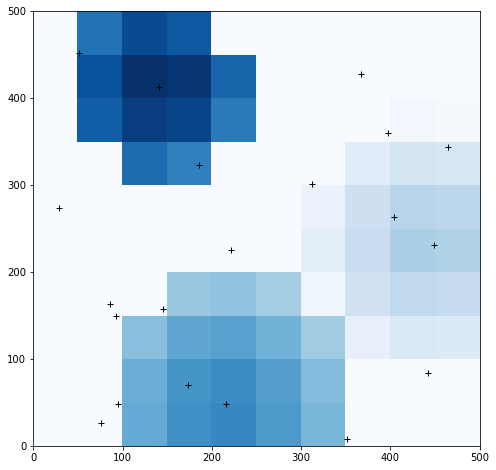

In [7]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set(xlim=[region.xmin, region.xmax], ylim=[region.ymin, region.ymax])

ax.pcolormesh(*prediction.mesh_data(), prediction.intensity_matrix, cmap="Blues")
ax.scatter(points.xcoords, points.ycoords, linewidth=1, marker="+", color="Black")
None

# As a continuous prediction

In [8]:
prediction = result.continuous_prediction()

In [9]:
prediction.cell_height = 5
prediction.cell_width = 5
grid = open_cp.predictors.GridPredictionArray.from_continuous_prediction(prediction, 100, 100)

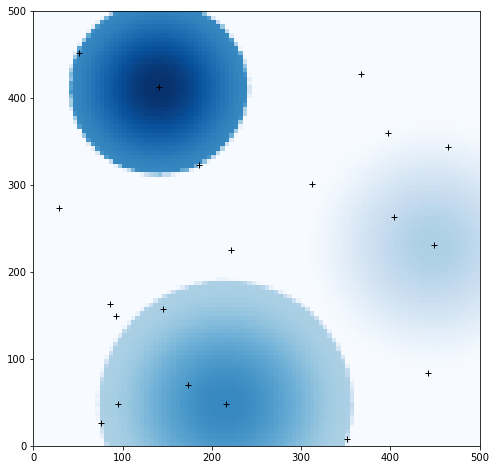

In [10]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set(xlim=[region.xmin, region.xmax], ylim=[region.ymin, region.ymax])

ax.pcolormesh(*grid.mesh_data(), grid.intensity_matrix, cmap="Blues")
ax.scatter(points.xcoords, points.ycoords, linewidth=1, marker="+", color="Black")
None

# Future work

I would very much like to look at some real crime data in order to tune this "predictor".